In [1]:
## Libraries
import numpy as np
import matplotlib.pyplot as plt

## Plot settings
plt.rc('xtick', direction='in', labelsize=14)
plt.rc('ytick', direction='in', labelsize=14)
plt.rc('axes', labelsize=20, titlesize=22)
plt.rc('legend', fontsize=14)

In [2]:
## Read coordinates and indices

grid_coordinates = []
with open('../Grids/AB_grid.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(',')
        point = (float(elements[0]),float(elements[1]))
        grid_coordinates.append(point)
        line = reader.readline()

jump_coordinates = []
with open('../Grids/AB_jump_coordinates.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(' ')
        data_block = []
        for ele in elements:
            temp = ele.replace('(', '').replace(')', '')
            if temp != 'stop':
                x = temp.split(',')[0]
                y = temp.split(',')[1]
                point = (float(x),float(y))
                data_block.append(point)
            else:
                break
        line = reader.readline()
        jump_coordinates.append(data_block)

jump_indices = []
with open('../Grids/AB_jump_indices.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(' ')
        data_block = []
        for ele in elements:
            if ele != 'stop':
                data_block.append(int(ele))
            else:
                break
        line = reader.readline()
        jump_indices.append(data_block)


# For drawing vertices use grid_coordinates
# For drawing lines use jump_coordinates
# For indices use jump_indices

In [3]:
## DEFINITION OF USEFUL FUNCTIONS

def Hamil_solve(z, B):
    # Define now a skeleton of the Hamiltonian 
    dim_H = len(z)
    H = np.zeros((dim_H, dim_H), dtype= np.complex128)
    k_H = [x for x in range(0, dim_H)]
    # Calculate Peierls phase factor according to the 1st artcle 
    l = tile_len
    phi = B * l**2
    phi_0 = 2 * np.pi
    jump_products = []
    for i, j in zip(z, total_jumps):
        products = [(k.imag - i.imag) * (i.real + k.real) for k in j]
        jump_products.append(products)
    phase_factors = []
    for i, j in zip(z, jump_products):
        phases = [(phi/(2 * l**2)) * k for k in j]
        phase_factors.append(phases)

    # Scaling via J, maybe energy factor
    J = 1
    # Fill out the Hamiltonian according to the psi vector, i.e. the basis chosen through generation of the tiling
    for x, y, z in zip(k_H, jump_indices, phase_factors):
        for k, t in zip(y, z):
            H[x, k] = J * np.exp(1j * t)

    # Now we find the eigenvalues and eigenvectors
    # Note that eigh returns normalized eigenvectors!
    # Note the eigenvectors are arranged in a matrix so eig_vecs[:,i] chooses the i'th column which is the i'th eigenvector
    eig_vals, eig_vecs = np.linalg.eigh(H)
    return eig_vals, eig_vecs


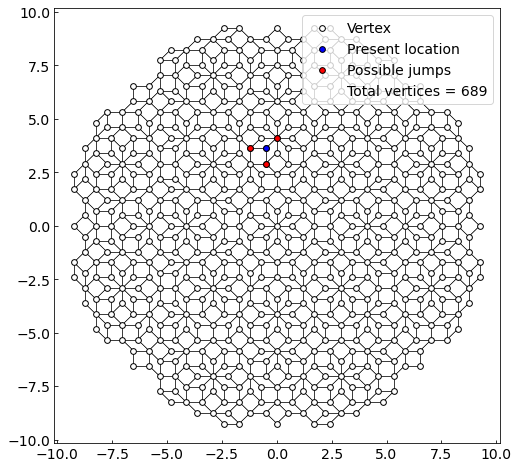

In [4]:
# Define figure
fig, ax = plt.subplots(figsize=(8,8))

# Plot all possible paths between vertices
for i,j in zip(grid_coordinates, jump_coordinates):
    xs = [w[0] for w in j]
    ys = [w[1] for w in j]
    for l,k in zip(xs,ys):
        ax.plot([i[0], l], [i[1], k], color= 'k', zorder= 1, linewidth= 0.5)

# Extract coordinates in cartesian terms
xs = [w[0] for w in grid_coordinates]
ys = [w[1] for w in grid_coordinates]

# Choose index to highlight a specific vertex and its connecting points
#ind_choice = int(len(z)*0.33)
ind_choice = 340

xs_jumps = [w[0] for w in jump_coordinates[ind_choice]]
ys_jumps = [w[1] for w in jump_coordinates[ind_choice]]

marker_size = 33

ax.scatter(x= xs, y= ys, s= marker_size, facecolor= 'w', edgecolor= 'k', label= "Vertex", linewidth= 1)
ax.scatter(x= xs[ind_choice], y= ys[ind_choice], s= marker_size, facecolor= 'b', edgecolor= 'k', label= "Present location", linewidth= 1)
ax.scatter(x= xs_jumps, y= ys_jumps, s= marker_size, facecolor= 'r', edgecolor= 'k', label= "Possible jumps", linewidth= 1)
ax.plot([],[], linestyle= '', label= "Total vertices = {}".format(len(grid_coordinates)))

ax.legend(loc= 1)

# IF YOU WANT TO SAVE IT. NAME IS IDENTICAL TO THAT OF OTHER AB TILING FILE
#plt.savefig('../Illustrations/hofstadter_AB_tiling.png')
plt.show()


In [5]:
# Take field strength of B= 2pi so that phi/phi0= 0.5
evals_mid, evecs_mid = Hamil_solve(grid_coordinates, 2*np.pi)

NameError: name 'tile_len' is not defined